# ERA5 map generator for atm 400 final project

---

## Overview
A team at [Google Research & Cloud](https://research.google/) are making parts of the [ECMWF Reanalysis version 5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) (aka **ERA-5**) accessible in a [Analysis Ready, Cloud Optimized](https://www.frontiersin.org/articles/10.3389/fclim.2021.782909/full) (aka **ARCO**) format.

In this notebook, we will do the following:

1. Access the [ERA-5 ARCO](https://github.com/google-research/arco-era5) catalog
1. Select a particular dataset and variable from the catalog


---

## Imports

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy import calc as mpcalc
from metpy.units import units
import metpy
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

## Access the ARCO ERA-5 catalog on Google Cloud

Let's open the **37-level isobaric surfaces reanalysis** Zarr file

In [2]:
reanalysis = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2', 
    consolidated=True
)

In [3]:
#displays the reanalysis dataset
reanalysis

<xarray.Dataset>
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>

In [81]:
#creates variable subsets
geop = reanalysis.geopotential
temp = reanalysis.temperature
slp = reanalysis.mean_sea_level_pressure
uwind = reanalysis.u_component_of_wind
vwind = reanalysis.v_component_of_wind

In [82]:
#creates potential temperature variable
p850 = 850 * units.hPa
Thta = mpcalc.potential_temperature(p850 , temp)
Thta = Thta.metpy.convert_units('degC')
#Thta

In [83]:
#geop








Select time and level ranges from the dataset.

In [84]:
#sets times and sets the time range
nHours = 72 
startTime = datetime(2007,1,9,0)
endTime = startTime + timedelta(hours=nHours)

<div class="alert alert-danger">
    <b>RESTRICT YOUR TIME/LEVEL RANGES!</b> <br>
The full dataset is over 70 TB ... if you try to load in too large a range (or forget to specify the start/stop points), you will likely run out of system memory!
/div>

In [103]:
#Further subsets variables into the desired time and pressure level if needed
geopSub1 = geop.sel(time=slice(startTime, endTime), level=850)
tempSub1 = temp.sel(time=slice(startTime, endTime), level=850)
tempSub2 = temp.sel(time=slice(startTime, endTime), level=500)
tempSub3 = temp.sel(time=slice(startTime, endTime), level=700)
slpSub1 = slp.sel(time=slice(startTime, endTime))
u500 = uwind.sel(time=slice(startTime, endTime), level=500)
v500 = vwind.sel(time=slice(startTime, endTime), level=500)
u700 = uwind.sel(time=slice(startTime, endTime), level=700)
v700 = vwind.sel(time=slice(startTime, endTime), level=700)
u850 = uwind.sel(time=slice(startTime, endTime), level=850)
v850 = vwind.sel(time=slice(startTime, endTime), level=850)
Thtasub1 = Thta.sel(time=slice(startTime, endTime))
u300 = uwind.sel(time=slice(startTime, endTime), level=300)
v300 = vwind.sel(time=slice(startTime, endTime), level=300)
U = uwind.sel(time=slice(startTime, endTime))
V = vwind.sel(time=slice(startTime, endTime))
#sftsub1 = sft.sel(time=slice(startTime, endTime))

Convert to dam and deg C.

In [104]:
#sets the variable "Z" to the array of geopotential height
Z = mpcalc.geopotential_to_height(geopSub1).metpy.convert_units('dam')

In [105]:
#sets variable T as temperature array
T = tempSub1.metpy.convert_units('degC')

In [106]:
#creates array of SLP denoted SLP
SLP = slpSub1.metpy.convert_units('hPa')

In [107]:
#creates a temperature subset at 500 and 700 hPa
T700 = tempSub3.metpy.convert_units('degC')
T500 = tempSub2.metpy.convert_units('degC')
T850 = tempSub1.metpy.convert_units('degC')

In [108]:
#creates "wspd" the dataset of windspeed
wspd = mpcalc.wind_speed(u300,v300)
#wspd

## Plot the data using Matplotlib

In [109]:
#assignes the variable projdata to the platecarre style projection
projData = ccrs.PlateCarree()

In [110]:
#variables lons and lats pulling longitude and latitude from the Z subset (this is the same for all sets) 
lons, lats = Z.longitude, Z.latitude

In [111]:
#sets map extent and creates variables for the map extent to be used in the next cell
#in ERA5 the extent goes from 0 being the right prime meridian to 360 being the left side of it
#A map seam will appear in the pacific ocean depending on extent used
lonW, lonE, latN, latS = 140, 300, 20, 80 

lonRange = np.arange(lonW, lonE)
latRange = np.arange(latN, latS)

In [112]:
#Creates spatial subsets of the data
ZSub2 = Z.sel(latitude = latRange + 5, longitude = lonRange +5)
TSub2 = T.sel(latitude = latRange + 5, longitude = lonRange + 5)
wspdsub2 = wspd.sel(latitude = latRange +5, longitude = lonRange +5)
T500 = T500.sel(latitude = latRange + 5, longitude = lonRange +5)
T700 = T700.sel(latitude = latRange + 5, longitude = lonRange +5)
T850 = T850.sel(latitude = latRange + 5, longitude = lonRange +5)
u500 = u500.sel(latitude = latRange + 5, longitude = lonRange +5)
u700 = u700.sel(latitude = latRange + 5, longitude = lonRange +5)
u850 = u850.sel(latitude = latRange + 5, longitude = lonRange +5)
v500 = v500.sel(latitude = latRange + 5, longitude = lonRange +5)
v700 = v700.sel(latitude = latRange + 5, longitude = lonRange +5)
v850 = v850.sel(latitude = latRange + 5, longitude = lonRange +5)
T = T.sel(latitude = latRange +5, longitude = lonRange +5)
U = U.sel(latitude = latRange +5, longitude = lonRange +5)
V = V.sel(latitude = latRange +5, longitude = lonRange +5)

In [113]:
#Variables for subtracting from map extent to make the data prettier
constrainLat, constrainLon = (0.5, 30)

In [114]:
#lon and lat subsets for the data arrays to be used (necessary for plotting)
lonsub = ZSub2.longitude
latsub = ZSub2.latitude
lonu = U.longitude
latu = U.latitude

In [131]:
#sets data indexes as well as max/min values for them
tLevels = np.arange(-45,39,3)
#zLevels = np.arange(468, 606, 6)
zLevels = np.arange(800,1000,6)
wspdLevels = np.arange(120,200,10)
dtlevels = np.arange(-20,20,5)
advlevels = np.arange(-5,5,2)

In [132]:
#sets a variable for using the lambert conformal projection
projMap = ccrs.LambertConformal(central_longitude=(lonW + lonE) / 2., central_latitude=(latS + latN) / 2.)

In [133]:
#creates a list of times to use for plotting with
times = pd.to_datetime(Z.time.values)
#times

<timed exec>:31: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.


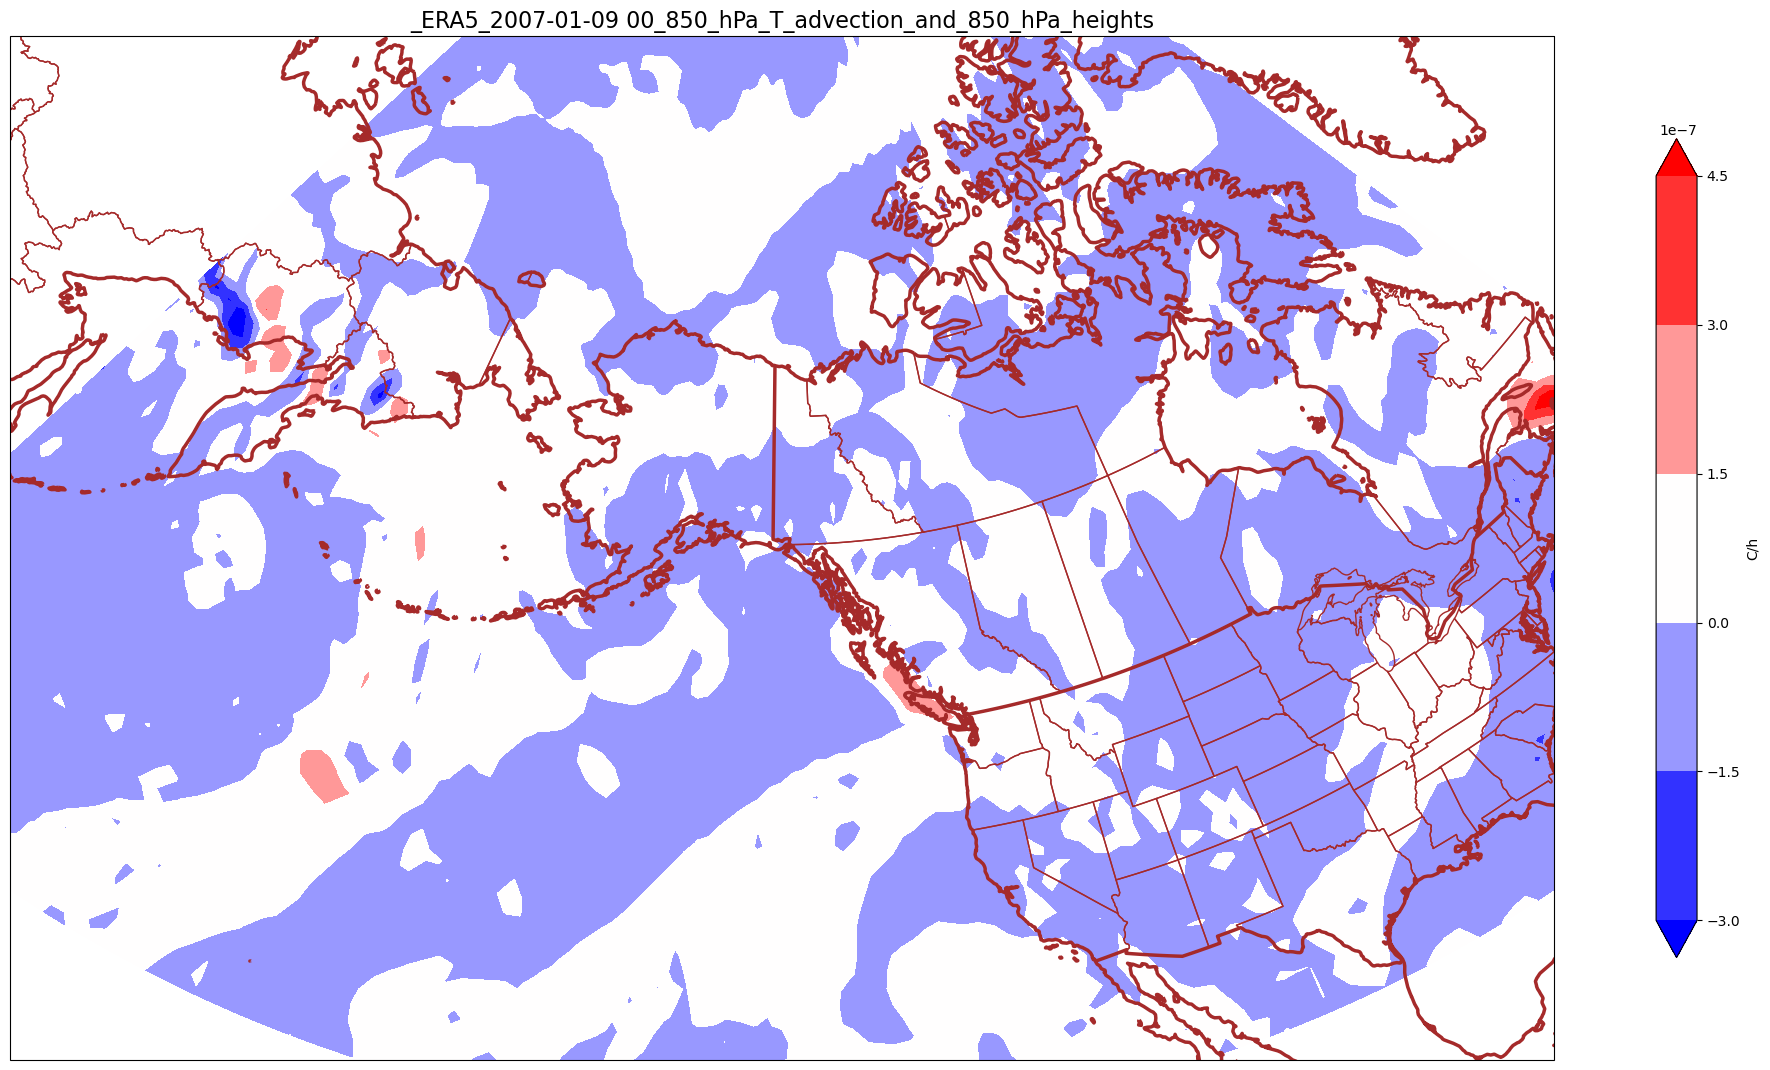

<timed exec>:31: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.


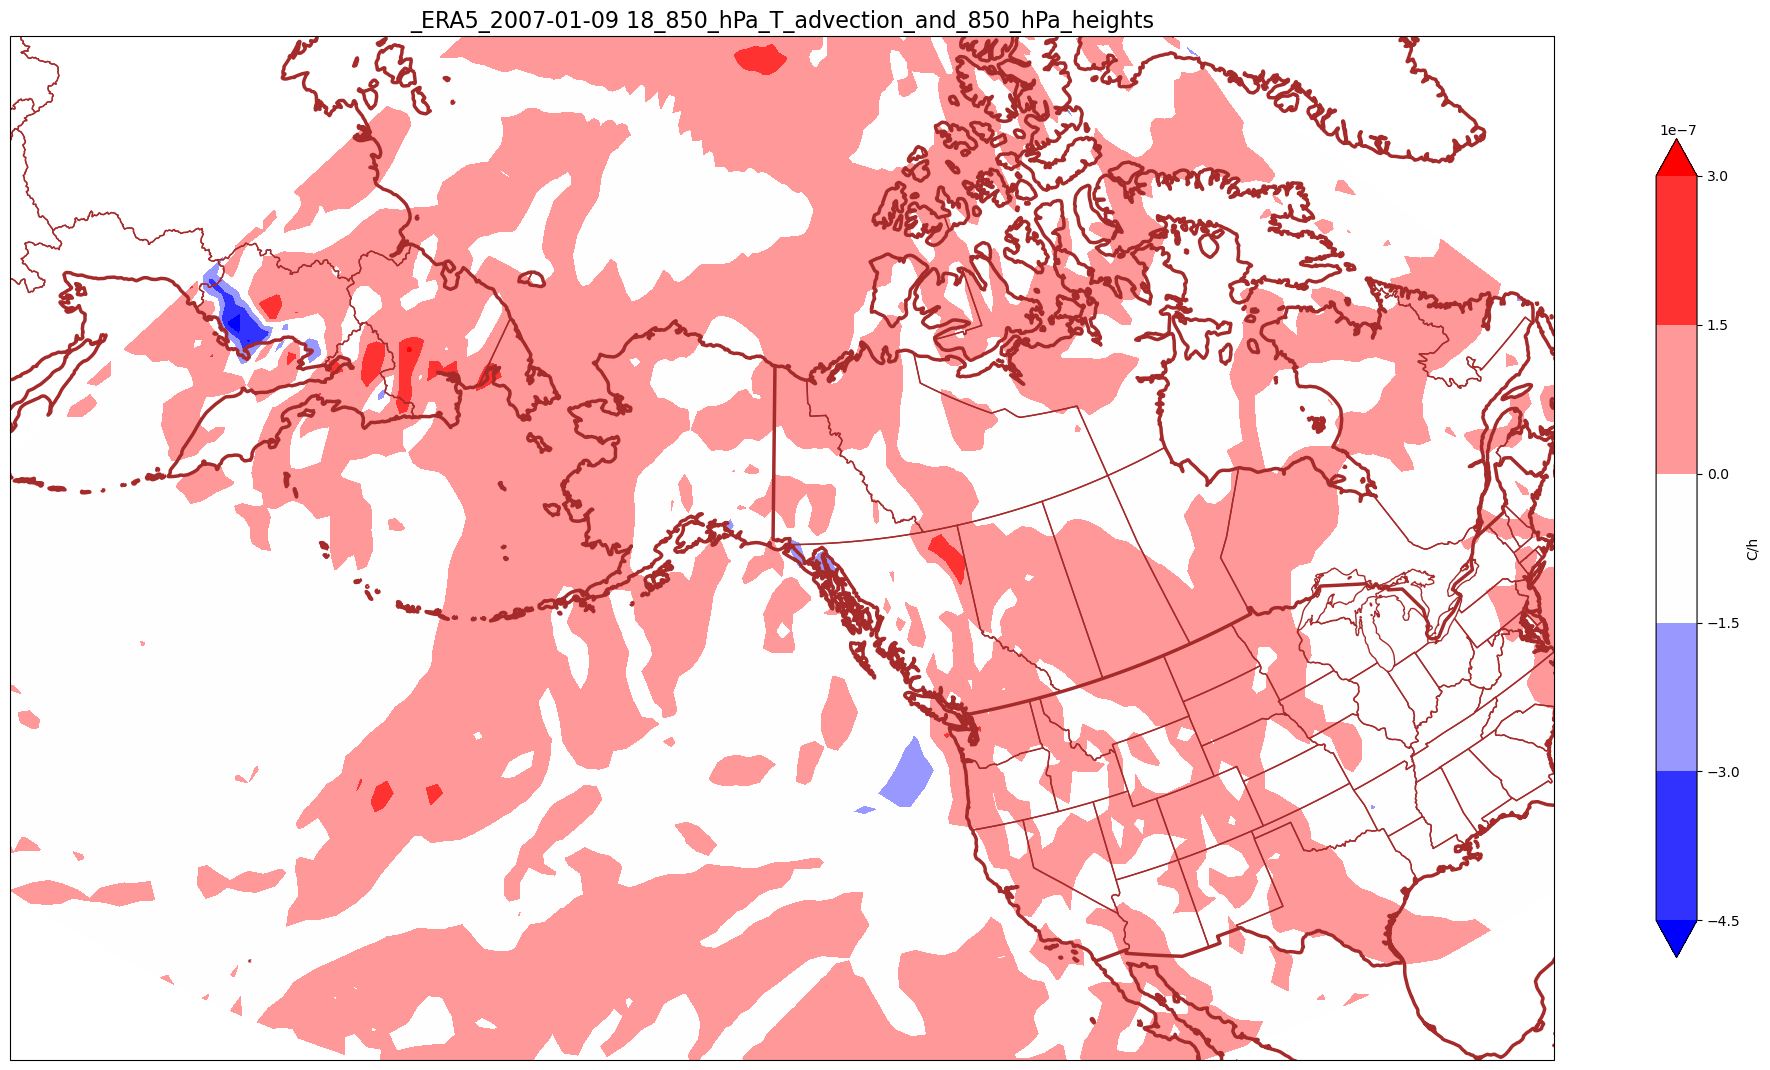

<timed exec>:31: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.


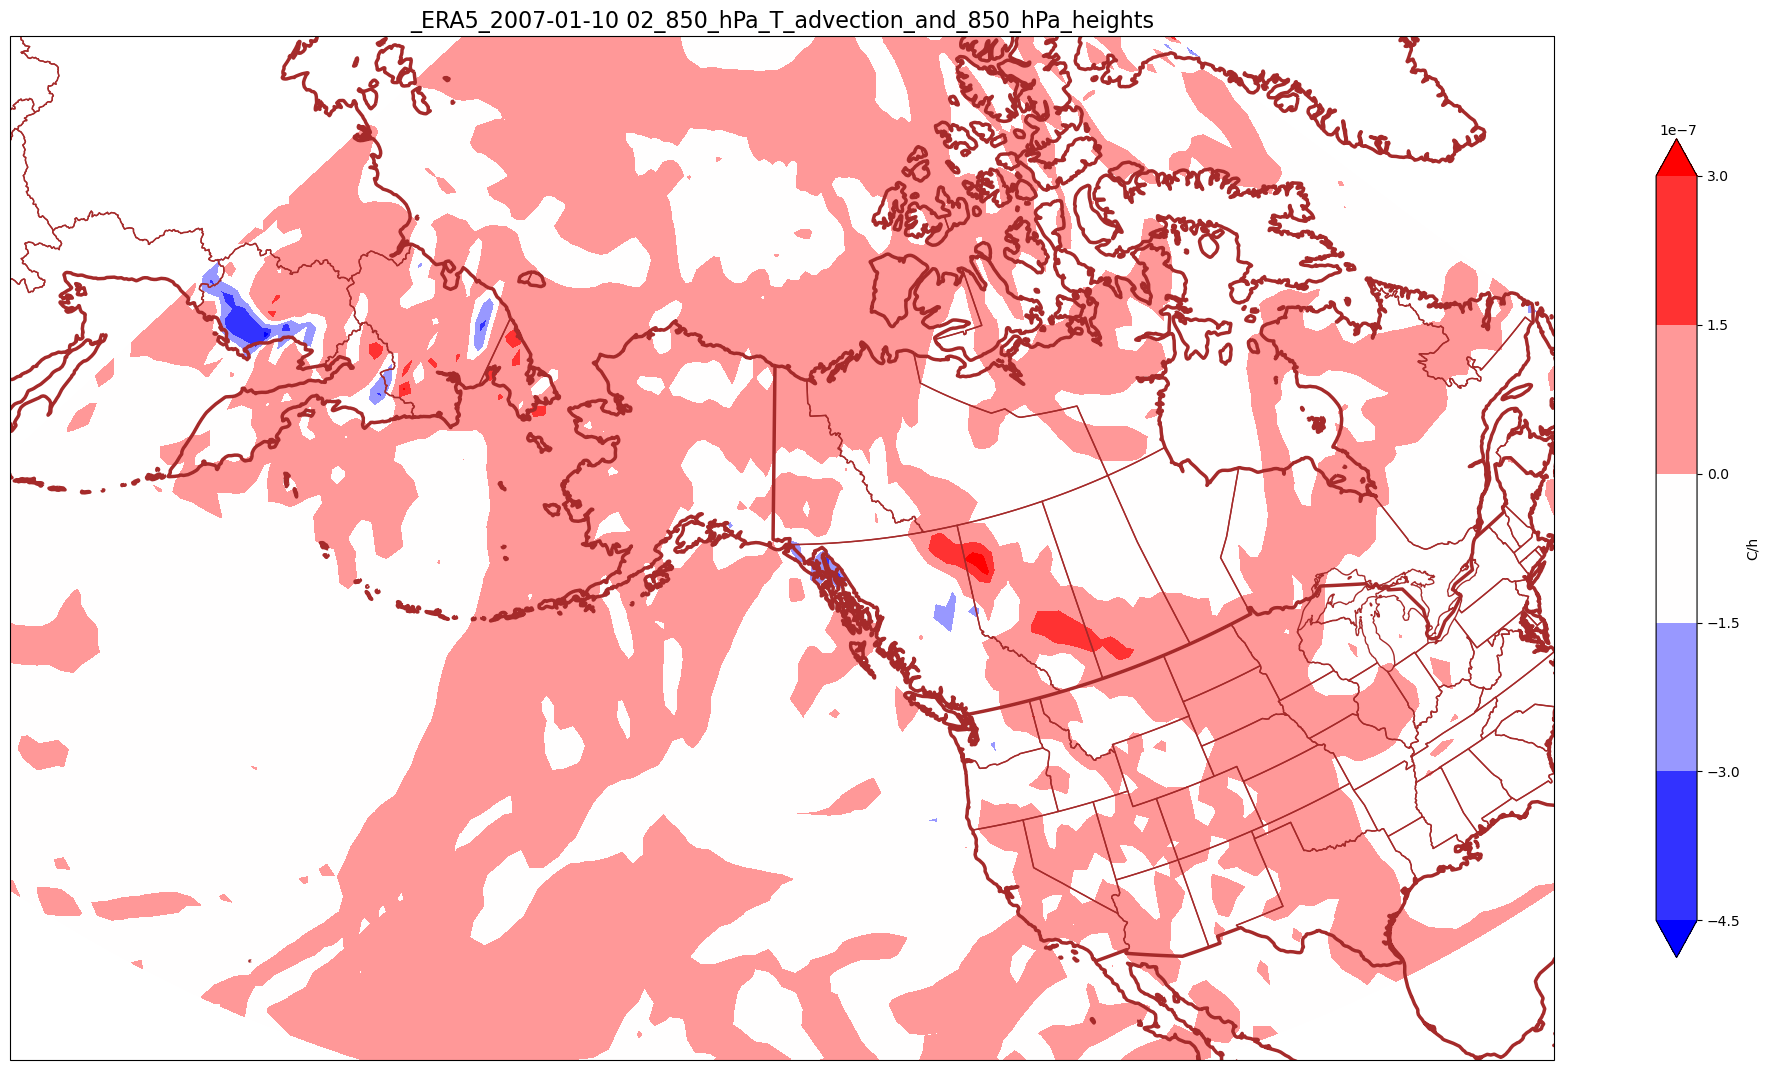

<timed exec>:31: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.


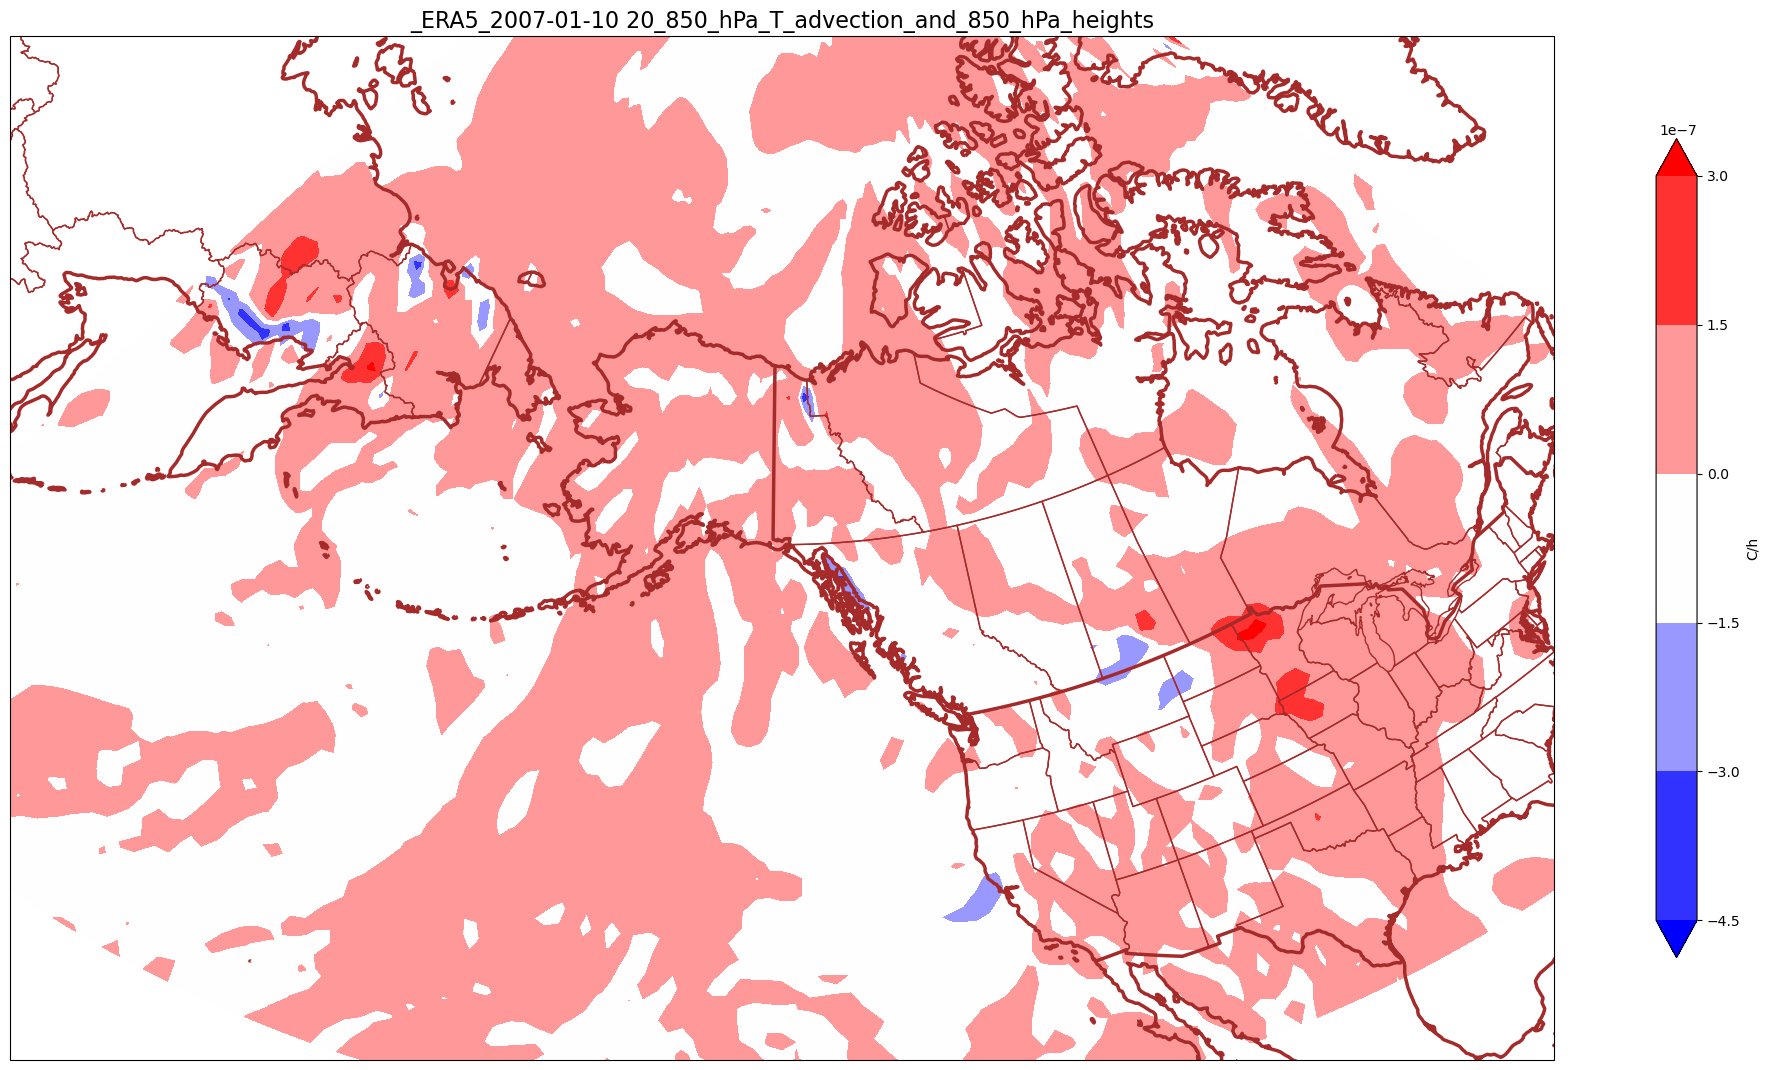

<timed exec>:31: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.


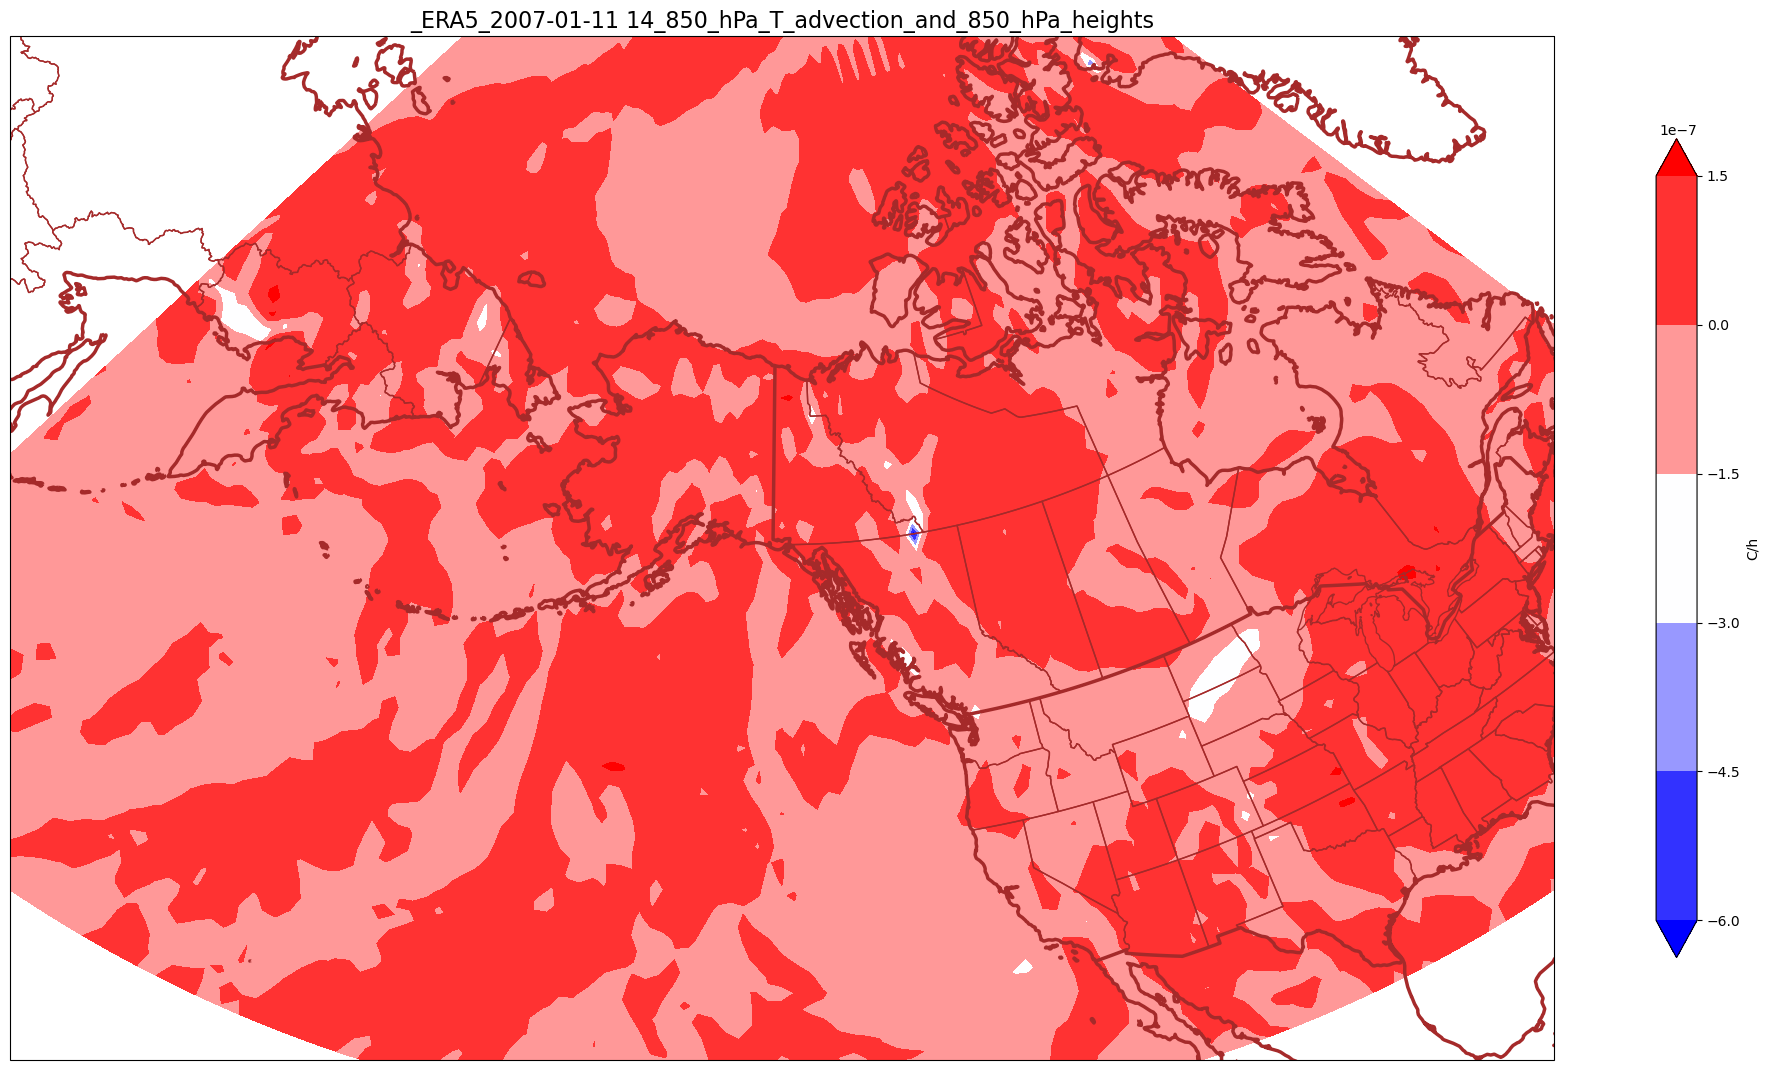

CPU times: user 51.5 s, sys: 11.3 s, total: 1min 2s
Wall time: 1min 34s


In [135]:

%%time 

timelist = [0,18,26,44,62]
#timelist = [1]
for step in timelist:
    #mapping things and features
    res = '50m'
    dpi = 100
    fig = plt.figure(figsize=(2048/dpi, 1024/dpi))
    ax = plt.subplot(1,1,1,projection=projMap)

    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res), edgecolor='brown', linewidth=2.5)
    ax.add_feature(cfeature.BORDERS.with_scale(res), edgecolor='brown', linewidth=2.5)
    ax.add_feature(cfeature.STATES.with_scale(res), edgecolor='brown')
    
   

    #Uncomment the appropriate lines below to plot desired variables
    
    #differential T advection
    #usub500 = u500.sel(time=times[step])
    #usub700 = u700.sel(time=times[step])
    usub850 = u850.sel(time=times[step])
    #vsub500 = v500.sel(time=times[step])
    #vsub700 = v700.sel(time=times[step])
    vsub850 = v850.sel(time=times[step])
    #Tsub500 = T500.sel(time=times[step])
    #Tsub700 = T700.sel(time=times[step])
    Tsub850 = T850.sel(time=times[step])
    #adv500 = mpcalc.advection(Tsub500,usub500,vsub500)
    #adv700 = mpcalc.advection(Tsub700,usub700,vsub700)
    adv850 = mpcalc.advection(Tsub850,usub850,vsub850)
    adv850 = (adv850 * (1/3600))
    #diffadv = adv500 - adv700 
    
    #CF = ax.contourf(lonsub,latsub,diffadv*1e4,levels=dtlevels,cmap=plt.get_cmap('PuOr'), extend='both', transform=projData)
    
    #T advection (uncomment necessary advection lines above)
    CF = ax.contourf(lonsub,latsub,adv850, cmap=plt.get_cmap('bwr'), extend='both', transform=projData)

    # Temperature (T) contour fills
    #CF = ax.contourf(lonsub, latsub, T.isel(time=step), levels=tLevels, cmap=plt.get_cmap('gist_rainbow_r'), extend='both', transform=projData) 
  
    #windspeed fill
    #CF = ax.contourf(lonsub,latsub,wspdsub2.isel(time=step),wspdLevels,cmap=plt.get_cmap('Blues'), extend='both', transform=projData) 

    cbar = fig.colorbar(CF,shrink=0.8)
    cbar.ax.set_ylabel("C/h",fontsize=10)
        
    # Height (Z) contour lines
    CL = ax.contour(lonsub,latsub,ZSub2.isel(time=step),zLevels,linewidths=1.25,colors='black', transform=projData)
    ax.clabel(CL, inline_spacing=0.2, fontsize=8, fmt='%.0f')
    fig.tight_layout(pad=.01)
    
    #wind Barbs
    #ax.barbs(lonu, latu, U.isel(time=step), V.isel(time=step), Levels = 850, transform=projData, length=6,zorder=4)

    titlebit1 = (times[step].strftime("%Y-%m-%d %H"))
    titlebit = ('_850_hPa_T_advection_and_850_hPa_heights')
    fname = str(titlebit1) + str(titlebit)
    
    title = plt.title('_ERA5_' + titlebit1 + titlebit,fontsize=16)
    plt.savefig('ERA5_' + fname,dpi=125)
    plt.show()
    
    plt.close


In [136]:
adv850

<xarray.DataArray 'neg-995bb949ba2452d601f204b07320f823' (latitude: 60,
                                                          longitude: 160)>
<Quantity(dask.array<mul, shape=(60, 160), dtype=float64, chunksize=(60, 160), chunktype=numpy.ndarray>, 'kelvin / second')>
Coordinates:
  * latitude   (latitude) float32 25.0 26.0 27.0 28.0 ... 81.0 82.0 83.0 84.0
    level      int64 850
  * longitude  (longitude) float32 145.0 146.0 147.0 148.0 ... 302.0 303.0 304.0
    time       datetime64[ns] 2007-01-11T14:00:00